Guy 2018-09-23

This is a fork on a GitHub from tjvandal (https://github.com/tjvandal/generic-pred/tree/master/julia)

Generic-Pred stand for "Generic-Prediction" and was introduced by Golestani Abbas & Robin Gras, 2014 paper "Can we predict the unpredictable?" (http://www.nature.com/articles/srep06834 and http://www.nature.com/articles/srep06834#supplementary-information)

It is about "an original approach that brings a novel perspective to the field of long-term time series forecasting".

One demonstrated application is Dow Jones Industrial Average (DJIA) forcasting. Authors seems to have used closing index data from September 1993 to September 2001:

"Extract from the paper"

<img src="Generic-Pred-DJIA compare forcasting.PNG" alt="Drawing" style="width: 600px;"/>

We have downloaded (http://quotes.wsj.com/index/DJIA/historical-prices) DJIA data from September 1st, 1993 to September 28, 2001. And found the code tjvandal put in its github.

Our intend is to reproduce Golestani Abbas & Robin Gras paper's demonstration on DJIA.

Objectives:
- Understand
- Add explanations and comments
- Compare tjvandal results with the paper
- Analyse some alternatives (TBD)


In [1]:
#Pkg.add("Distributed") #https://docs.julialang.org/en/v1/stdlib/Distributed/index.html
#Pkg.add("Gadfly") # install GadFly if not already present
#Pkg.add("DataFrames") # install DataFrames if not already present
#Pkg.update() # get the latest versions of your packages

push!(LOAD_PATH, pwd()) #LOAD_PATH contains the directories Julia searches for modules : pwd() Get the current working directory

3-element Array{Any,1}:
 "C:\\Program Files\\Julia-0.6.4\\local\\share\\julia\\site\\v0.6"
 "C:\\Program Files\\Julia-0.6.4\\share\\julia\\site\\v0.6"       
 "c:\\Users\\guypa\\Documents\\GitHub\\Generic-Pred"              

In [2]:
using DataFrames #DataFrames package provides the essential tools you need for working with statistical data
using Gadfly #Gadfly is a system for plotting and visualization
using CSV # fast and flexible pure-Julia library for handling delimited text files

# @everywhere using Lyaponuv # @everywhere : this tag will insure that all the processes have access to the function
# @everywhere is a way to include a fonction library. Here, the fonctions are within this notebook
# Lyaponuv is a distinct file with all the functions. I have inserted those function in the next cell.

f = "DJIA 09-1993 to 09-2001.csv" 
# a File name which is a .csv containing two columns Date and DJIA
# Dow Jones Industrial Average from Sept 01, 1993 to Sept 28, 2001

#data=readtable(f, header=true) #read data from a CSV-like file
data=CSV.read(f)


INFO: Precompiling module DataFrames.
The method will not be callable.
INFO: Precompiling module Gadfly.
INFO: Precompiling module CSV.


,Date,DJIA
1,1993-09-01,3645.1
2,1993-09-02,3626.1
3,1993-09-03,3633.93
4,1993-09-07,3607.1
5,1993-09-08,3588.93
6,1993-09-09,3589.49
7,1993-09-10,3621.63
8,1993-09-13,3634.21
9,1993-09-14,3615.76
10,1993-09-15,3633.65


In [3]:
#using Distributed #https://docs.julialang.org/en/v1/stdlib/Distributed/index.html
addprocs(16) #add 4 processes on the local machine. This can be used to take advantage of multiple cores.

@everywhere function lyaponuv_k(time_series, J, m, ref)
    #println("test:1")
    X = attractor(time_series, m, J)
    #println("test:2")
    norms = compute_norms(X)
    #println("test:3")
    pairs = match_pairs(norms)
    #println("test:4")
    y = follow_points(pairs, norms, ref)
    #println("test:5")
    return(norms,y)
end

@everywhere function match_pairs(norms)
    M = size(norms)[1]
    pairs = Array{Int}(M)
    for row in 1:M
        mn, idx = findmin(norms[row, :])
        pairs[row] = idx
    end
    return(pairs)
end

@everywhere function attractor(time_series, m, J)
    N = length(time_series)
    M = N - (m - 1) * J  
    X = Array{Float64}(m, M)
    i = 1
    for i=1:M
        X[:,i] = time_series[i:J:(i+(m-1)*J)]
    end
    return(X)
end

@everywhere function follow_points(pairs, norms, ref)
    y = Array{Float64}(ref)
    M = size(norms)[1]
    for i=0:ref-1
        agg = 0 
        count = 0
        for j=1:M
            jhat = pairs[j]+i
            jtrue = j+i

            if jhat <= M && jtrue <= M
                agg = agg + log(norms[jtrue, jhat])
               # agg = agg + log(vecnorm(X[:, jtrue] - X[:, jhat]))
                count = count + 1
            end
        end
        y[i+1] = agg/count # divide by delta-t also?
    end
    return(y)
end


@everywhere function compute_norms(X)
    M = size(X)[2]
norms = Array{Float64}(M, M)
    for i=1:M
        norms[i,:] = column_norms(X, i)      
    end    
    return(norms)
end


@everywhere function column_norms(X, i)
    M = size(X)[2]
    X_diff = X .- X[:, i]
    norm_vector = [vecnorm(X_diff[:, k]) for k=1:M]
    norm_vector[i] = 10^10
    return(norm_vector)
end


@everywhere function lyaponuv_exp(series)
    nn = .!isnan.(series)
    A = ones(length(series), 2)
    A[:,1] = linspace(1, length(series), length(series))
    gradient = \(A, series)
    return(gradient[1])
end


@everywhere function lyaponuv(time_series, J, m, ref)
    ts = lyaponuv_k(time_series, J, m, ref)[2]
    exponent = lyaponuv_exp(ts[isfinite.(ts)])  ## only input those which are finite
    return(exponent)
end

@everywhere function get_next(ts, m, M, norms, ref, J)
    
    attractor_array = attractor(ts, m, J)
    temp_norms = Array{Float64}(M+1, M+1)
    temp_norms[1:M, 1:M] = norms
    col = column_norms(attractor_array, M+1)
    temp_norms[M+1, :] = col
    temp_norms[:, M+1] = col

    pairs=match_pairs(temp_norms)
    lyap_k_temp = follow_points(pairs, temp_norms, ref)
    return(lyaponuv_exp(lyap_k_temp))
end

@everywhere function lyaponuv_next(time_series, J, m, ref, sample_size)
    ts_diff = time_series[2:end] - time_series[1:end-1]
    sigma = std(ts_diff)
    samples = randn(sample_size) * sigma + time_series[end]
    @time norms, lyap_k = lyaponuv_k(time_series, J, m, ref)
    true_exponent = lyaponuv_exp(lyap_k)
    exponents = Array{Float64}(sample_size)
    M = size(norms)[1]
    tasks = Array{Future}(sample_size)

    for i=1:sample_size
        s = samples[i]
        tasks[i] = @spawn get_next(vcat(time_series, s), m, M, norms, ref, J)
        #@time exponents[i] = get_next(vcat(time_series, s), m, M, norms, ref, J)        
        #@printf("process: %d\n", i) 
    end
    
    for i=1:sample_size
        exponents[i]=fetch(tasks[i])
    end

    diff = abs.(exponents .-  true_exponent)    
    val, idx = findmin(diff)
    println("Next Value:", samples[idx])
    return(samples[idx])
end

In [4]:
#Variables needed by lyaponuv function
J = 2  ## reconstruction delay
m = 3  ## embedding dimension
r = 11 ## 

sliding_window = 1400
next_x_points = 521
sample_size = 10

ts = deepcopy(data[:DJIA][1:end-next_x_points])/10000 
#Create a deep copy of "data", everything is copied recursively, resulting in a fully independent object.
#The copy lenghy has next_x_points less points than the original "data"
#Futhurmore, each points is divided per 10000

#println("ts:", ts, "\n")
#println("length(ts):", length(ts), "\n")
#println("length(ts[1:end-1]):", length(ts[1:end-1]), "\n")
#println("length(ts[2:end]):", length(ts[2:end]), "\n")

diff = ts[1:end-1] - ts[2:end]
#

#println("diff:", diff, "\n")
#println("length(diff):", length(diff), "\n")
#println("diff avg:", mean(abs.(diff)), "\tdiff std:", std(diff))

ta1=now()
println("start_time:", ta1)
for i=1:next_x_points
    #println("i:", i, ":")
    lyap_exp = lyaponuv(ts[end-sliding_window:end], J, m, r)
    #println("lyap_exp:", lyap_exp, "\n")
    tasks = Array{Future}(sample_size)
    #println("tasks:", tasks, "\n")
    mu = mean(ts[end-sliding_window:end])
    #println("mu:", mu, "\n")

    diff = ts[end-sliding_window+1:end] - ts[end-sliding_window:end-1]
    mu = mean(diff)
    #println("mu:", mu, "\n")
    sigma = std(diff)
    #println("sigma:", sigma, "\n")

    sample_values = randn(sample_size) .* sigma .+ ts[end]
    #println("sample_values:", sample_values, "\n")

    for j=1:sample_size
        #println("j:", j, "\n")
        tempts=deepcopy(ts[end-sliding_window:end])
        #println("tempts:", tempts, "\n")
        append!(tempts, [sample_values[j]])
        #println("sample_values:", sample_values, "\n")
        tasks[j] = @spawn lyaponuv(tempts, J, m, r)
        #println("tasks[j]:", tasks[j], "\n")
    end
    
    exponents = Array{Float64}(sample_size)
    #println("exponents:", exponents, "\n")
    
    for j=1:sample_size
        #println("j:", j, "\n")
        exponents[j] = fetch(tasks[j])
        #println("exponents[j]:", exponents[j], "\n")
    end
    #println("exponent:", mean(lyap_exp))
    
    exp_diff = abs.(exponents .- lyap_exp)
    min_index = findmin(exp_diff)
    best_val = sample_values[min_index[2]]
    append!(ts, [best_val])
    #println(i, "   best value:", best_val, "\t")
end
ta2=now()
println("end_time:",ta2)
println(ta2-ta1)

# use writetable("output.csv", df) To write data to a CSV file -> deprecated USE CSV.writer instead

start_time:2018-10-03T09:22:17.981
end_time:2018-10-03T09:28:11.309
353328 milliseconds


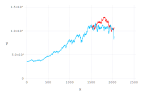

In [6]:
x=linspace(1, length(data[:DJIA]), length(data[:DJIA]))
l1 = layer(x=x, y=data[:DJIA], Geom.line)

x0 = length(data[:DJIA])-next_x_points+1
x_ts = linspace(x0, length(ts), length(ts)-x0+1)
y_ts = ts[x0:end]*10000
l2 = layer(x=x_ts, y=y_ts, Geom.line, Theme(default_color=colorant"red"))
plot(l1, l2)
